# **Проект по А/B-тестированию**

**Задача:** провести оценку результатов A/B-теста.

**Техническое задание**

- Название теста: recommender_system_test;

- Группы: А (контрольная), B (новая платёжная воронка);

- Дата запуска: 2020-12-07;

- Дата остановки набора новых пользователей: 2020-12-21;

- Дата остановки: 2021-01-04;

- Аудитория: 15% новых пользователей из региона EU;

- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

- Ожидаемое количество участников теста: 6000.

- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
-
> конверсии в просмотр карточек товаров — событие product_page
-
> просмотры корзины — product_cart
-
> покупки — purchase.


## **Загрузка данных и библиотек, изучение общей информации о данных.**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st

In [2]:
try:
  marketing_events, users, events, participants = (
      pd.read_csv('ab_project_marketing_events.csv', parse_dates = ['start_dt', 'finish_dt']),
      pd.read_csv('final_ab_new_users.csvv', parse_dates = ['first_date']),
      pd.read_csv('final_ab_events.csv', parse_dates = ['event_dt']),
      pd.read_csv('final_ab_participants.csv')
)
except:
  marketing_events, users, events, participants = (
      pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', parse_dates = ['start_dt', 'finish_dt']),
      pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv', parse_dates = ['first_date']),
      pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv', parse_dates = ['event_dt']),
      pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
)


Ознакомимся с данными

In [3]:
for elem in (marketing_events, users, events, participants):
  display(elem.head(5))
  print('\n')
  elem.info()
  print('\n')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes




,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB




,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB




,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB




### **Вывод по разделу**

На первый взгляд все данные в таблицах представлены в корректном типе, названия столбцов приведены к хорошему стилю. Пропуски присутствуют лишь в столбце details таблицы events, но судя по описанию, в данном столбце присутствуют дополнительные данные о событии и к некоторым событиям они просто могут отсутствовать и это не является ошибкой.

## **Предобработка данных**

### *Проверим данные на явные дубликаты*

Завернём в функцию проверку на явные дубликаты для всех наших таблиц.


In [4]:
dict_datasets = {
    'marketing_events' : marketing_events,
    'users' : users,
    'events' : events,
    'participants' : participants
}

def get_duplicated(data_dict):
  for name, dataset_item in data_dict.items():
    print('Количество дубликатов в', name, ':',  dataset_item.duplicated().sum())
  return

get_duplicated(dict_datasets)

Количество дубликатов в marketing_events : 0
Количество дубликатов в users : 0
Количество дубликатов в events : 0
Количество дубликатов в participants : 0


### *Проверим данные на наличие аномальных значений*

Таблица marketing_events

Оценим временной диапазон данных представленных в столбцах start_dt  и finish_dt

In [5]:
print('Минимальная дата начала кампании', marketing_events['start_dt'].min())
print('Максимальная дата начала кампании', marketing_events['start_dt'].max())
print('\n')
print('Минимальная дата завершения кампании', marketing_events['finish_dt'].min())
print('Максимальная дата завершения кампании', marketing_events['finish_dt'].max())

Минимальная дата начала кампании 2020-01-25 00:00:00
Максимальная дата начала кампании 2020-12-30 00:00:00


Минимальная дата завершения кампании 2020-02-07 00:00:00
Максимальная дата завершения кампании 2021-01-07 00:00:00


Из дат видно, что период нашего теста мог пересекаться с какими-то проводящимися кампаниями, посмотрим какие именно кампании проходили в какой период.

In [6]:
marketing_events.sort_values(by=['start_dt'])


,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


В период нашего теста проходило 2 компании - Рождественская и новогодняя акция (25.12.2020 - 03.01.2021) и Лотерея новогодних подарков (30.12.2020 - 07.01.2021)

С учетом того, что набор новых пользователей закончился 21.12.2020 в данных не присутсвуют пользователи, которые пришли в результате этих компаний.


Таблица users

In [7]:
column_list = list(users)

for column_name in column_list:
      print(column_name)
      print(users[column_name].unique())
      print('\n')

user_id
['D72A72121175D8BE' 'F1C668619DFE6E65' '2E1BF1D4C37EA01F' ...
 '7ADEE837D5D8CBBD' '1C7D23927835213F' '8F04273BB2860229']


first_date
['2020-12-07T00:00:00.000000000' '2020-12-14T00:00:00.000000000'
 '2020-12-21T00:00:00.000000000' '2020-12-08T00:00:00.000000000'
 '2020-12-15T00:00:00.000000000' '2020-12-22T00:00:00.000000000'
 '2020-12-09T00:00:00.000000000' '2020-12-16T00:00:00.000000000'
 '2020-12-23T00:00:00.000000000' '2020-12-10T00:00:00.000000000'
 '2020-12-17T00:00:00.000000000' '2020-12-11T00:00:00.000000000'
 '2020-12-18T00:00:00.000000000' '2020-12-12T00:00:00.000000000'
 '2020-12-19T00:00:00.000000000' '2020-12-13T00:00:00.000000000'
 '2020-12-20T00:00:00.000000000']


region
['EU' 'N.America' 'APAC' 'CIS']


device
['PC' 'Android' 'iPhone' 'Mac']




Оценим временной диапазон данных представленных в столбце first_date

In [8]:
print('Минимальная дата регистрации пользователя', users['first_date'].min())
print('Максимальная дата регистрации пользователя', users['first_date'].max())

Минимальная дата регистрации пользователя 2020-12-07 00:00:00
Максимальная дата регистрации пользователя 2020-12-23 00:00:00


В таблице выявлены пользователи зарегестрированные в период позднее 21.12.2020, что противоречит ТЗ. Удалим этих пользователей.

Таблица events

In [9]:
column_list = list(events)

for column_name in column_list:
      print(column_name)
      print(events[column_name].unique())
      print('\n')

user_id
['E1BDDCE0DAFA2679' '7B6452F081F49504' '9CD9F34546DF254C' ...
 'C9F1399FDCD83F13' '4F32B58E4FF19DC5' '27767D4BECDD260E']


event_dt
['2020-12-07T20:22:03.000000000' '2020-12-07T09:22:53.000000000'
 '2020-12-07T12:59:29.000000000' ... '2020-12-30T12:21:24.000000000'
 '2020-12-30T10:54:15.000000000' '2020-12-30T10:59:09.000000000']


event_name
['purchase' 'product_cart' 'product_page' 'login']


details
[ 99.99   9.99   4.99 499.99    nan]




В таблице присутствуют данные по следующим событиям:

'purchase' - покупка

'product_cart' - переход в корзину товаров

'product_page' - переход на страницу продукта

'login' - вход в систему.

In [10]:
print('Минимальная дата события', events['event_dt'].min())
print('Максимальная дата события', events['event_dt'].max())

Минимальная дата события 2020-12-07 00:00:33
Максимальная дата события 2020-12-30 23:36:33


Минимальная дата событий в таблице совпадает с указанной в ТЗ, а вот максимальная дата должна быть 04.01.2021, а в данных присутствуют события только до 30.12.2020

Посмотрим по каким события отсутствуют данные в столбце details

In [11]:

events.groupby('event_name').agg(count = ('details', 'count')).reset_index()

,event_name,count
0,login,0
1,product_cart,0
2,product_page,0
3,purchase,62740


Данные в столбце присутствуют только по событию purchase, как и описывалось в ТЗ для покупок в этом поле хранится стоимость покупки в долларах. Для осатльных событий дополнительной информации не предоставлено.

Таблица participants

In [12]:
column_list = list(participants)

for column_name in column_list:
      print(column_name)
      print(participants[column_name].unique())
      print('\n')

user_id
['D1ABA3E2887B6A73' 'A7A3664BD6242119' 'DABC14FDDFADD29E' ...
 'F501F79D332BE86C' '63FBE257B05F2245' '79F9ABFB029CF724']


group
['A' 'B']


ab_test
['recommender_system_test' 'interface_eu_test']




В таблице присутствуют данные ещё по одному тесту помимо recommender_system_test.

### **Выводы по разделу**

1. Дубликатов в таблицах не обнаружено.
2. В период нашего теста проходило 2 компании - Рождественская и новогодняя акция (25.12.2020 - 03.01.2021) и Лотерея новогодних подарков (30.12.2020 - 07.01.2021).
3. В таблице users выявлены и удалены пользователи зарегестрированные в период позднее 21.12.2020.
4. Минимальная дата событий в таблице events совпадает с указанной в ТЗ, а вот максимальная дата должна быть 04.01.2021, а в данных присутствуют события только до 30.12.2020.
5. В таблице  participants обнаружены данные ещё по одному тесту помимо recommender_system_test.

## **Оценим корректность проведения теста.**



### ***Проверим данные на соответствие требованиям технического задания.***

Название теста: recommender_system_test;

Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Аудитория: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемое количество участников теста: 6000.

In [13]:
#выделим только тест recommender_system_test
recommender_system_test = participants.query('ab_test == "recommender_system_test"')
interface_eu_test = participants.query('ab_test == "interface_eu_test"')

In [14]:
recommender_system_test.groupby('group').agg(count_users = ('user_id', 'count'))


,count_users
group,
A,3824
B,2877


В тесте recommender_system_test присутсвтуют две группы А и В.

Ранее в предобработке данных мы выявили, что минимальная дата событий в таблице совпадает с указанной в ТЗ, а вот максимальная дата должна быть 04.01.2021, а в данных присутствуют события только до 30.12.2020, почему-то тест остановиле раньше планируемой даты окончания.

Так же во время предобработки мы заметили в данных пользователей зарегестрированные в период позднее 21.12.2020, хотя в соответствии с ТЗ дата остановки набора новых пользователей: 2020-12-21. Было приянто решение удалить всех пользователей, зарегестрировавшихся после 21.12.2021г.



Проверим утверждение ТЗ, что аудитория - 15% новых пользователей из региона EU.
Для начала просчитаем доли всех новых пользователей в разбивке по регионам.


In [15]:
all_users = users.groupby('region').agg(count_all_users = ('user_id', 'count')).reset_index()
all_users

,region,count_all_users
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


Теперь присоединим к таблице users таблицу recommender_system_test, тем самым оставив только тех пользователей которые попали в тест recommender_system_test и проделаем ту же группировку что и раньше.

In [16]:
recommender_system_test_users = users.merge(recommender_system_test, on='user_id')
test_users = recommender_system_test_users.groupby('region').agg(count_users = ('user_id', 'count')).reset_index()
test_users

,region,count_users
0,APAC,72
1,CIS,55
2,EU,6351
3,N.America,223


Объединим полученные таблицы и посчиаем долю пользователей в тесте от общего числа новых пользователей для каждого региона.

In [17]:
region_users= test_users.merge(all_users, on = 'region')
region_users['share'] = region_users['count_users']/region_users['count_all_users']
region_users


,region,count_users,count_all_users,share
0,APAC,72,3153,0.022835
1,CIS,55,3155,0.017433
2,EU,6351,46270,0.137260
3,N.America,223,9155,0.024358


Рассчёты совпадают с данными ТЗ, аудитория по EU действительно 15% новых пользователей EU.
Очистим данные recommender_system_test_users от остальных регионов.

In [18]:
test = recommender_system_test_users.query('region == "EU"')
test.head(10)

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
3,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
4,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
7,16C69ED14DA9F4A8,2020-12-07,EU,PC,B,recommender_system_test
8,3C5DD0288AC4FE23,2020-12-07,EU,PC,A,recommender_system_test
9,2420EA89BB4BB0EA,2020-12-07,EU,iPhone,A,recommender_system_test
10,4D851A41ECF4440F,2020-12-07,EU,Android,B,recommender_system_test
11,B27F5380AF0936D3,2020-12-07,EU,Android,A,recommender_system_test


Посмотрим, есть ли клиенты попавшие в обе группы.

In [19]:
bad_users = test.groupby('user_id').agg({'group' : 'nunique'}).reset_index().query('group>1')['user_id']
bad_users

Series([], Name: user_id, dtype: object)

Таких пользователей не обнаружено.

In [20]:
print('Количество участников в тесте:', test['user_id'].nunique())

Количество участников в тесте: 6351


Количество участников в тесте незначительно привысило ожидаемое значение в 6000.

### ***Время проведения теста.***

Во время предобработки мы уже замечали, что время проведения теста пересекается с маркетинговыми событиями, посмотрим на них ещё раз.

In [21]:
marketing_events.query('"2020-12-07" < start_dt < "2021-01-03"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Одно из событий не затрагивает региеон в котором проходил тест, поэтому повлиять на тест может только событие Рождественская и новогодняя акция (25.12.2020 - 03.01.2021).

### ***Аудитория теста***

Ранее мы выявили что внутри теста recommender_system_test нет клиентов попаших  в обе группы теста (А и В).
Теперь убедимся, что нет пересечений с конкурирующим тестом.
Для этого посмотрим, присутствуют ли пользователи, входящие в оба теста сразу


In [22]:
participants['user_id'].duplicated().sum()


1602

Таких пользователей выявлено 1602.
Создадим список этих пользователей.



In [23]:
duplicat = participants[participants.duplicated('user_id')]['user_id'].to_list()

С учтом того, что группа А теста interface_eu_test это контрольная группа, пеерсечение с пользвателями из неё не повлияет на наш тест, т.к. пользователи не видели ни каких изменений в рамках теста interface_eu_test. А вот пересечение с группой В теста interface_eu_test нужно исключить.
Выявим список user_id дубликатов в группе В теста interface_eu_test и исключим эти user_id из данных по тесту recommender_system_test.

In [24]:
duplicat_interface_В = interface_eu_test.query('group == "B" & user_id in @duplicat')
#duplicat_interface_В['user_id'].count()
duplicat_interface_В= duplicat_interface_В['user_id'].to_list()
#duplicat_interface_В

# исключим выявленные дубликаты из данных по тесту recommender_system_test

test = test.query('user_id not in @duplicat_interface_В')
print('Количество участников в тесте:', test['user_id'].nunique())


Количество участников в тесте: 5568


In [25]:
us = test.groupby('group').agg(count_users = ('user_id', 'count')).reset_index()
us['share'] = us['count_users']/us['count_users'].sum()
us

,group,count_users,share
0,A,3195,0.573815
1,B,2373,0.426185


Распределение по пользователям произведено не равномерно, в группе А присутствуют 57%, а в группе В 43% пользователей, но несбалансированност групп не так страшна, главное, что они у нас достаточно большие.

### **Выводы по разделу**

1. Данные не по всем пунктам соответствуют ТЗ:
 - минимальная дата событий в таблице совпадает с указанной в ТЗ, а вот максимальная нет, в данных присутствуют события только до 30.12.2020, почему-то тест остановиле раньше планируемой даты окончания.
 - обнаружены и удалены пользователеи зарегестрированные в период позднее 21.12.2020.
 - аудитория очищена от других регионов и составляет 15% новых пользователей из региона EU.
 - Количество участников в тесте незначительно привысило ожидаемое значение и составила 6351.

2. В календаре маркетинговых событий присутствует акция, которая затрагивает регион, в котором проходит тест и может повлиять на результаты - Рождественская и новогодняя акция (25.12.2020 - 03.01.2021).

3. Внутри теста recommender_system_test нет клиентов попаших в обе группы теста (А и В).

4. Выявлены пересечения пользователей с конкурирующим тестом. Пользователи попавшие и в наш тест и в группу В конкурирующего теста были удалены из данных. После чего количество участников тесат составило 5568.

5.  Распределение по пользователям произведено не равномерно, в группе А присутствуют 57%, а в группе В 43% пользователей, но группы достаточно большие.



## **Исследовательский анализ данных**

Для дальнейшей работы создадим итоговый файл теста присоединив к уже имеющемуся test данные из файла events

In [26]:
data_test = test.merge(events, how='left', on = 'user_id')

data_test.head(5)

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN


По условиям ТЗ ожидается, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%.
Посчитаем их лайфтайм и уберем события события, которые были совершены после 14 дней с даты регистрации.

In [27]:
data_test['life_time'] = (data_test['event_dt'] - data_test['first_date']).dt.days
data_test =data_test[data_test['life_time'] <= 14]

Построим воронку событий для групп в виде таблицы.

In [28]:
events_users= (
    data_test.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')
    .sort_values(by=['A', 'B'], ascending=False)
    .reset_index())
events_users.columns = ['event_name', 'group_A', 'group_B']
events_users = events_users.reindex(index=[0, 1, 3, 2])
events_users['conversion_A'] = (events_users['group_A'] / data_test.query('group == "A"')['user_id'].nunique()).transform(lambda x: '{:,.0%}'.format(x))
events_users['conversion_B'] = (events_users['group_B'] / data_test.query('group == "B"')['user_id'].nunique()).transform(lambda x: '{:,.0%}'.format(x))
events_users['conversion_per_step_A']= (events_users['group_A']/(events_users['group_A'].shift(1))).transform(lambda x: '{:,.2%}'.format(x))
events_users['conversion_per_step_B']= (events_users['group_B']/(events_users['group_B'].shift(1))).transform(lambda x: '{:,.2%}'.format(x))
events_users

events_users

,event_name,group_A,group_B,conversion_A,conversion_B,conversion_per_step_A,conversion_per_step_B
0,login,2279,770,100%,100%,nan%,nan%
1,product_page,1476,429,65%,56%,64.77%,55.71%
3,product_cart,686,214,30%,28%,46.48%,49.88%
2,purchase,734,219,32%,28%,107.00%,102.34%


Воронка получилась изначально немного странного вида, событие покупка шло до события Продукт в корзине, поэтому пришлось переместиль эти события местами, в результате наша воронка имеет следующий вид.

**Воронка событий**

'login' - вход в систему

'product_page' - переход на страницу продукта

'product_cart' - переход в корзину товаров

'purchase' - покупка

In [29]:
fig = go.Figure(go.Funnel(
    x = events_users['group_A'],
    y = events_users['event_name']))
fig.update_layout(title_text='Процент пользователей в группе А перешедших на следующий этап относительно первого этапа воронки')
fig.show()


In [30]:
fig = go.Figure(go.Funnel(
    x = events_users['group_B'],
    y = events_users['event_name']))
fig.update_layout(title_text='Процент пользователей в группе B перешедших на следующий этап относительно первого этапа воронки')
fig.show()


По воронке наблюдаем сильные различия в численности между группами А и В, без разбивки на события разница в количесвте пользователей не была на столько существенной. Конверсия в группе В ниже чем в группе А. До покупки в группе А доходят 32%, а в группе В 28%. Так же видно что конверсия пользователей на шаге Покупка превышает пользователей на шаге Переход в корзину товаров, видимо совершить покупку можно минуя шаг перехода в корзину.

***Распределение количества событий на пользователя.***

Посчитаем число событий на одного пользователя в разбивке по группам

In [31]:
event_user = data_test.groupby('group').agg(count_user = ('user_id', 'nunique'), count_event = ('event_name', 'count')).reset_index()
event_user['event_per_user'] =(event_user['count_event'] / event_user['count_user']).round(2)
event_user

,group,count_user,count_event,event_per_user
0,A,2279,15851,6.96
1,B,771,4183,5.43


Дополнительно посмотрим более детальную разбивку ещё по событиям в группах.

In [32]:
event_user = data_test.groupby(['group', 'event_name']).agg(count_user = ('user_id', 'nunique'), count_event = ('event_name', 'count')).reset_index()
event_user['event_per_user'] =(event_user['count_event'] / event_user['count_user']).round(2)
event_user

,group,event_name,count_user,count_event,event_per_user
0,A,login,2279,7018,3.08
1,A,product_cart,686,2114,3.08
2,A,product_page,1476,4514,3.06
3,A,purchase,734,2205,3.00
4,B,login,770,2036,2.64
5,B,product_cart,214,542,2.53
6,B,product_page,429,1074,2.50
7,B,purchase,219,531,2.42


Количество событий на пользователя в выборках в группе А выше чем в группе В.

***Распределение числа событий в выборках по дням***

Создадим дополнительный столбец выделив из столбца event_dt только дату без времени.

In [33]:
data_test['event_dt_data'] = data_test['event_dt'].dt.date


In [34]:
events_by_date = (data_test.groupby(['event_dt_data', 'group'], as_index=False)['event_name'].count()
                                .rename(columns={'event_name':'event_count'}))
events_by_date.head()

,event_dt_data,group,event_count
0,2020-12-07,A,263
1,2020-12-07,B,315
2,2020-12-08,A,283
3,2020-12-08,B,207
4,2020-12-09,A,331


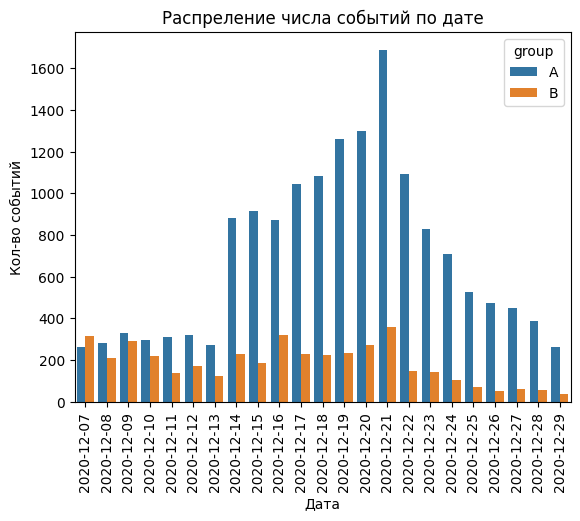

In [35]:
sns.barplot(x = 'event_dt_data', y = 'event_count', data = events_by_date,  hue='group')
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.title('Распреление числа событий по дате')
plt.show ()


Из диаграммы видно, что в группе А с 14.12.2020 пошел резкий рост числа событий, пик по ним наблюдается 21.12.2020, затем до конца тестового периода наблюдается снижение числа событий. Напомним, что по календарю маркетинговых событий как раз 25.12.2020 началась Росждественская и новогодняя акция.
В группе В не наблюдается каких-то динамики сопоставимой с груупой А в период с 14 по 25 декабря, но 25.12.2020 всё же так же виден рост заказов и после снижение так же до конца тестового периода.

### **Вывод по разделу**

1. Количество событий на пользователя распределены не равномерно, число чобытий в группе А превышает число в группе В.
2. Наблюдаются сильные различия в численности между группами А и В, группа А значительно больше.
3. Конверсия пользователей на шаге Покупка превышает пользователей на шаге Переход в корзину товаров в обоих группах, видимо совершить покупку можно минуя шаг перехода в корзину.
4. Конверсия в группе В ниже чем в группе А. До покупки в группе А доходят 32%, а в группе В 28%.
5. По числу событий группа А намного активнее группы В, хотя на начало теста по числу событий они не сильно отличались. В обоих группах виден пик активности 25.12.2020, как раз в период начала Рождественской и новогодней акции. Так же к концу теста число событий в группе В намного ниже чем в начале теста, а в группе В примерно равно значениям в начале теста.

Таким образом ожидаемый эффект (за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%) не был достигнут.

## **Проведём оценку результатов A/B-тестирования**

Походу работы над проектом регулярно обнаруживались нарушения, такие как отличие в распределения количества пользователей в группах теста, наличие в период теста маркенинговой акции, пересечение пользователей с конкурирующим тестом, данные присутствуют не за весь период теста а только до 30.12.2020 (возможно тест завершили раньше), некоторые условия тех.здания не были выполнены.
В результате ожидаемый эффект, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10% не был достигнут.


***Проверим статистическую разницу долей z-критерием.***

Проверим, будет ли отличие между группами А и В статистически достоверным.

Для начала добавим некоторые данные в нашу таблицу с воронкой.

In [36]:
events_users['all_users_A'] = data_test.query('group == "A"')['user_id'].nunique()
events_users['all_users_B'] = data_test.query('group == "B"')['user_id'].nunique()
events_users

,event_name,group_A,group_B,conversion_A,conversion_B,conversion_per_step_A,conversion_per_step_B,all_users_A,all_users_B
0,login,2279,770,100%,100%,nan%,nan%,2279,771
1,product_page,1476,429,65%,56%,64.77%,55.71%,2279,771
3,product_cart,686,214,30%,28%,46.48%,49.88%,2279,771
2,purchase,734,219,32%,28%,107.00%,102.34%,2279,771


Сформулируем гипотезы

**H0: различий в долях групп А и В нет.**

**H1: между долями есть значимая разница.**

In [37]:
from statsmodels.stats.proportion import proportions_ztest
def z_test(alpha, event, group1, group2, total_group1, total_group2):
  count = np.array([events_users.loc[events_users['event_name'] == event, group1], events_users.loc[events_users['event_name']== event,group2]])
  nobs = np.array([events_users.loc[events_users['event_name']== event, total_group1], events_users.loc[events_users['event_name']== event, total_group2]])
  #alpha = 0.05  # критический уровень статистической значимости
  stat, p_value = proportions_ztest(count, nobs)

  print ('Результаты теста для групп', group1, 'и', group2)
  print ('Событие', event)
  print ('p_value: ', p_value.round(3))


  if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
  else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')



In [38]:
# выделим события в отдельный список
event_names = list(events_users['event_name'])
event_names

['login', 'product_page', 'product_cart', 'purchase']

Далее у нас будет проводились множественные проверки и для снижения вероятности ложнопозитивного результа нужно применить метод корректировки уровня значимости, например Бонферрони, поделя уровень значимости на число проверок гипотез. В нашем случае будет 4 проверки, и скорректированный уровень значимости будет равен 0,05/4 = 0,0125. При этом нужно помнить, что боясь совершить ошибку первого рода и уменьшая уровень значимости мы рискуем множество успешных экспериментов признать не успешными. У нас будет проходить не так много проверок, поэтому в данном случае применение поправки Бонферрони не опасно, при увеличении числа проверок нужно было задуматься о применении другой поправки.

In [39]:
#проверим, будет ли отличие между группами статистически достоверным.
for event in event_names:
  z_test(0.0125, event, 'group_A', 'group_B', 'all_users_A', 'all_users_B')
  print( )


Результаты теста для групп group_A и group_B
Событие login
p_value:  [0.086]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп group_A и group_B
Событие product_page
p_value:  [0.]
Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста для групп group_A и group_B
Событие product_cart
p_value:  [0.217]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста для групп group_A и group_B
Событие purchase
p_value:  [0.049]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



### **Вывод по разделу**

Согласно проведенным тестам различия между группами A и B по всем событиям, кроме product_page являются статистически незначимыми. Таким образом можно сказать, что изменения, связанных с внедрением улучшенной рекомендательной системы, повлияло на пользователей только на шаге перехода на страницу продукта, а в остальном не дало ни какого результата.



# **Итоговый вывод**

В результате проведенного АВ теста ожидаемый эффект, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10% не был достигнут.

Но при этом к проведению самого теста есть много вопросов, таких например, как время его проведения. Мало того, что тест пересекался с одной из маркетинговых кампаний, так ещё и выбор самого времени его проведения в декабре, когда и без внедрения улучшений ежегодно идёт рост потребительской активности в предверии новогодних праздников, крайне не корректен.

Так же были выявлены и другие нарушенияи, такие как не выполнение некоторых условий ТЗ, различия в распределении пользователей по группам, пересечение пользователей с конкурирующим тестом.

Возможно поэтому мы видели данные не за весь срок теста, а только до 30.12.2020, т.к. инициатор заметил множественные нарушения и решил завершить тест досрочно.

Таким образом рекомендовано не считать результат теста верными и запустить его повторно при корректном соблюдении условий.

